In [48]:
import os
import shutil
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.model_selection import train_test_split

with tf.device('/CPU:0'):
    
    train_data = ImageDataGenerator(rescale=1./255)

    normal_data_dir = '../opt/datasets/chest_xray/small_data/balanced/train_balanced/'
    #validation_data_dir = '../opt/datasets/chest_xray/small_data/balanced/validation_balanced/'

    train_gen = train_data.flow_from_directory(normal_data_dir,target_size=(150,150),batch_size=20,class_mode='binary') 
    #val_gen = train_data.flow_from_directory(validation_data_dir,target_size=(150,150),batch_size=20,class_mode='binary')    

Found 2160 images belonging to 2 classes.
Found 538 images belonging to 2 classes.


In [36]:
import pathlib
# K-fold aproach
data_path = pathlib.Path(r'../opt/datasets/chest_xray/small_data/balanced/')

# list of all images
img_path = list(data_path.glob('**/*.jpeg'))

# list of labels of datasets
img_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], img_path))

In [37]:
# Labels names
pandas_img_path = pd.Series(img_path,name = 'PATH').astype('string')
pandas_img_labels = pd.Series(img_labels, name='LABELS').astype(str)

# Creating table
img_dataframe = pd.merge(pandas_img_path, pandas_img_labels, right_index=True, left_index=True)
# Adding the index
img_dataframe = img_dataframe.sample(frac = 1).reset_index(drop=True)
img_dataframe.head()

,PATH,LABELS
0,../opt/datasets/chest_xray/small_data/balanced...,PNEUMONIA
1,../opt/datasets/chest_xray/small_data/balanced...,PNEUMONIA
2,../opt/datasets/chest_xray/small_data/balanced...,NORMAL
3,../opt/datasets/chest_xray/small_data/balanced...,PNEUMONIA
4,../opt/datasets/chest_xray/small_data/balanced...,NORMAL


In [38]:
img_dataframe['LABELS'].value_counts(ascending=True)

PNEUMONIA    1349
NORMAL       1349
Name: LABELS, dtype: int64

In [39]:
from sklearn.model_selection import KFold, train_test_split

train_dataset, test_dataset = train_test_split(img_dataframe, train_size=0.9, shuffle=True, stratify=img_dataframe['LABELS'])

In [58]:
from tensorflow.keras import layers
from tensorflow.keras import models

my_model = models.Sequential()
my_model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(150,150,3)))
my_model.add(layers.MaxPooling2D((2,2)))
my_model.add(layers.Conv2D(64,(3,3),activation="relu"))
    #my_model.add(layers.MaxPooling2D((2,2)))
    #my_model.add(layers.Conv2D(128,(3,3),activation="relu"))
my_model.add(layers.MaxPooling2D((2,2))) # riduco size
my_model.add(layers.Conv2D(128,(3,3),activation="relu"))
my_model.add(layers.MaxPooling2D((2,2))) # riduco size
my_model.add(layers.Flatten())
my_model.add(layers.Dropout(0.5))# unita di input settate a 0 random per evitare overfit
my_model.add(layers.Dense(128,activation="relu"))
my_model.add(layers.Dense(1,activation='sigmoid'))
my_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 36992)            

In [59]:
from tensorflow.keras import optimizers

with tf.device('/GPU:0'):
    METRICS = ['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
    histories=[]
    my_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=METRICS)
    EPOCHS = 12
    
    '''
    data_arg = ImageDataGenerator(rescale=1/255.,rotation_range=30,
        width_shift_range=0.1,# traslazione verticale
        height_shift_range=0.1,# traslazione orizontale
        zoom_range=0.1,#zoommare
        vertical_flip=True,
        fill_mode='nearest',#come riempire i pixel dopo traslazione e shift
        validation_split=0.2) 
    '''
    
    train_data = ImageDataGenerator(rescale=1./255)

#print(len(train_dataset))
    kfold = KFold(5, shuffle=True, random_state = 42)

    for f, (trn_ind, val_ind) in enumerate(kfold.split(train_dataset)):
        print(); print("#"*50)
        print("Fold: ",f+1)
        print("#"*50)
    
        train_ds = train_data.flow_from_dataframe(img_dataframe.loc[trn_ind,:], 
                                         x_col='PATH', y_col='LABELS',
                                         target_size=(150,150),
                                         class_mode = 'binary', color_mode = 'rgb',
                                         batch_size = 16, shuffle = True)
        val_ds = train_data.flow_from_dataframe(img_dataframe.loc[val_ind,:], 
                                       x_col='PATH', y_col='LABELS',
                                       target_size=(150,150),
                                       class_mode = 'binary', color_mode = 'rgb',
                                       batch_size = 16, shuffle = True)
        fold_start_epoch = f * EPOCHS
        fold_end_epoch = EPOCHS * (f+1)
        history=my_model.fit(train_ds, initial_epoch=fold_start_epoch , epochs=fold_end_epoch, validation_data=val_ds, shuffle=True)
        histories.append(history)


##################################################
Fold:  1
##################################################
Found 1942 validated image filenames belonging to 2 classes.
Found 486 validated image filenames belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 122 steps, validate for 31 steps
Epoch 1/12
122/122 [==============================] - 20s 162ms/step - loss: 0.3829 - accuracy: 0.8234 - precision: 0.8181 - recall: 0.8308 - val_loss: 0.1635 - val_accuracy: 0.9506 - val_precision: 0.9465 - val_recall: 0.9544
Epoch 2/12
122/122 [==============================] - 19s 159ms/step - loss: 0.1802 - accuracy: 0.9382 - precision: 0.9372 - recall: 0.9391 - val_loss: 0.2872 - val_accuracy: 0.8909 - val_precision: 0.8264 - val_recall: 0.9876
Epoch 3/12
122/122 [==============================] - 19s 159ms/step - loss: 0.1201 - accuracy: 0.9552 - precision: 0.9556 - recall: 0.9546 - val_loss: 0.2206 - val_accuracy: 0.9280 - val_precision: 0.8787 - val_recall: 

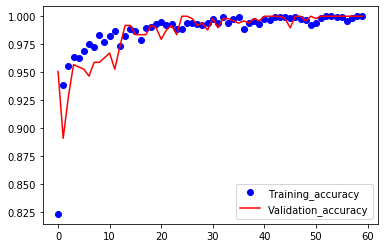

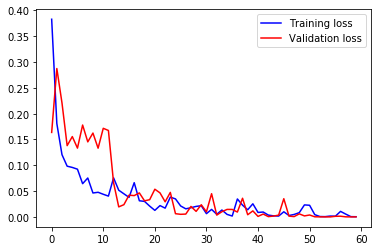

In [61]:
import matplotlib.pyplot as plt

acc, val_acc = [], []
loss, val_loss = [], []
for i in range(len(histories)):
    acc += histories[i].history['accuracy']
    val_acc += histories[i].history['val_accuracy']
    loss += histories[i].history['loss']
    val_loss += histories[i].history['val_loss']
  
total_epoch = len(histories) * len(history.epoch) # num of fold * each epoch 
epochs = range(total_epoch)
plt.plot(epochs,acc,'bo',label='Training_accuracy')
plt.plot(epochs,val_acc,'r',label='Validation_accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.legend()
plt.show()

In [62]:
test_gen = train_data.flow_from_directory('/opt/datasets/chest_xray/test/',target_size=(150,150),batch_size=32,class_mode='binary')

results = my_model.evaluate(test_gen)

Found 624 images belonging to 2 classes.
  ...
    to  
  ['...']
20/20 [==============================] - 3s 139ms/step - loss: 2.9193 - accuracy: 0.8061 - precision: 0.7685 - recall: 0.9872


[[0.0299335]]


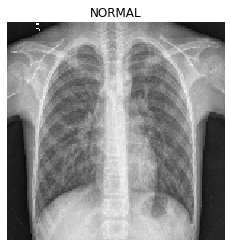

In [15]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os 

k_fold = load_model('./Kfold_argumented.h5')

fnames = [ os.path.join('../../opt/datasets/chest_xray/chest_xray/test/NORMAL/',fname) for fname in os.listdir('../../opt/datasets/chest_xray/chest_xray/test/NORMAL/')  ]
image_path= fnames[30]

img = tf.keras.preprocessing.image.load_img(image_path,target_size=(150,150))
plt.figure(figsize=(4,4))
plt.axis('off')
plt.title('NORMAL')
plt.imshow(img)

rescaler=ImageDataGenerator(rescale=1./255)
x = tf.keras.preprocessing.image.img_to_array(img)
x = x.reshape((1,) + x.shape )# adding a dimension

res=k_fold.predict(rescaler.flow(x))
print(res)# Prob of having PNEUMONIA